## Telecom Churn Prediction
- Train Three ML Models with different features combination:
      1) using all features  
      2) removing wieghted features  
      3) removing less important features 
 
- Compare Results

In [41]:
from utilties import *
from get_pred import *

In [42]:
sns.set()
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected = True)
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option('display.width', None)

In [43]:
import session_info
session_info.show()

## Get Data

In [45]:
df_data = pd.read_pickle('data/df_data.pkl')
df_val = pd.read_pickle('data/df_validation.pkl')
df_data.shape

(2999, 28)

In [60]:
df_data.columns

Index(['eve calls', 'eve minutes', 'night calls', 'total day calls',
       'Duration', 'night minutes', 'Call day minutes', 'international calls',
       'international minutes', 'vmail', 'w_eve calls', 'w_eve minutes',
       'w_night calls', 'w_total day calls', 'w_Duration', 'w_night minutes',
       'w_Call day minutes', 'w_international calls',
       'w_international minutes', 'w_vmail', 'gender', 'SeniorCitizen',
       'Product: International', 'Product: Voice mail', 'Phone Code',
       'PaperlessBilling', 'service calls', 'churn'],
      dtype='object')

In [83]:
wieghted_feats = ['w_eve calls', 'w_eve minutes','w_night calls', 'w_total day calls', 'w_Duration', 'w_night minutes',
       'w_Call day minutes', 'w_international calls','w_international minutes', 'w_vmail']
less_imp_feats = ['gender' , 'Phone Code' , 'SeniorCitizen','Duration','w_night calls','night calls','w_Duration','eve calls',
                  'w_total day calls','total day calls','w_eve minutes']

## Steps involved
- Try models: 'dummy_classifier', 'k_nearest_neighbors','logistic_regression', 'support_vector_machines','random_forest', 'gradient_boosting'
- Select suitable model
- Tune Hyperparamters (max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)
- Find best Model 
- Analyse results

In [80]:
def Train_ML_Model(DF):
    X = DF.drop(columns='churn')
    y = DF.loc[:, 'churn']
    print(X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=40, shuffle=True)
    models = create_models()

    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        model.fit(X_train, y_train).predict(X_test)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        results.append(accuracy)
        names.append(name)
        print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

    print('\n\n','-'*50,' Train RF Model', '-'*50)
    rfc = RandomForestClassifier(class_weight = 'balanced',random_state=100,n_jobs = -1)
    rfc.fit(X_train,y_train)
    Get_ROC(rfc, X_test, y_test)
    print('\n\n','-'*50,' Perform hyperparameter tuning wrt individual parameters', '-'*50)
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'max_depth', 
                          PARAMETER={'max_depth': range(2, 25, 1)}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'n_estimators', 
                          PARAMETER={'n_estimators': [10,25,50,75,100]}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'min_samples_split', 
                          PARAMETER={'min_samples_split': range(10,200,10)}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'min_samples_leaf', 
                          PARAMETER={'min_samples_leaf': range(10,200,10)}, N_FOLD=3, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'max_features', 
                          PARAMETER={'max_features': range(5,16,3)}, N_FOLD=3, TARGET="precision")

    print('\n\n','-'*50,' Perform hyperparameter tuning ', '-'*50)
    param_grid = {
        'max_depth': [10,13,15,17,20],
        'min_samples_split': [5,10,15], 
        'min_samples_leaf': [5,8,11,14,17] }

    rf = RandomForestClassifier(class_weight = 'balanced',random_state=100)
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, #scoring='precision',
                              cv = 3, n_jobs = -1,verbose = 1,return_train_score=True)

    grid_search.fit(X_train, y_train)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

    rf = RandomForestClassifier(bootstrap=True,random_state=100,
                                 max_depth=grid_search.best_params_['max_depth'],
                                 min_samples_split=grid_search.best_params_['min_samples_split'],
                                  class_weight='balanced')
    rf.fit(X_train,y_train)
    Get_ROC(rf, X_test, y_test)
    print('\n\n','-'*50,' Plot Feat importance  ', '-'*50)
    Get_RF_Model_Feat_Importance(rf, X_train.columns, len(X_train.columns))
    return rf, X_train.columns.to_list()

# Model 1 - Use all features

Index(['eve calls', 'eve minutes', 'night calls', 'total day calls',
       'Duration', 'night minutes', 'Call day minutes', 'international calls',
       'international minutes', 'vmail', 'w_eve calls', 'w_eve minutes',
       'w_night calls', 'w_total day calls', 'w_Duration', 'w_night minutes',
       'w_Call day minutes', 'w_international calls',
       'w_international minutes', 'w_vmail', 'gender', 'SeniorCitizen',
       'Product: International', 'Product: Voice mail', 'Phone Code',
       'PaperlessBilling', 'service calls'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8626666666666667)
Classifier: logistic_regression, Accuracy: 0.8453333333333334)
Classifier: support_vector_machines, Accuracy: 0.8573333333333333)
Classifier: random_forest, Accuracy: 0.9413333333333334)
Classifier: gradient_boosting, Accuracy: 0.9493333333333334)


 --------------------------------------------------  Train RF Model ----------

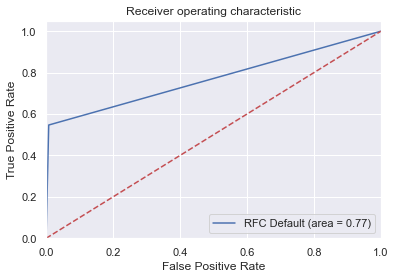

Area under curve is: 0.77
Recall for our model is: 0.55
Accuracy on test set is: 0.92
[[628   5]
 [ 53  64]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       633
           1       0.93      0.55      0.69       117

    accuracy                           0.92       750
   macro avg       0.92      0.77      0.82       750
weighted avg       0.92      0.92      0.91       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.931336542899636
{'max_depth': 13}


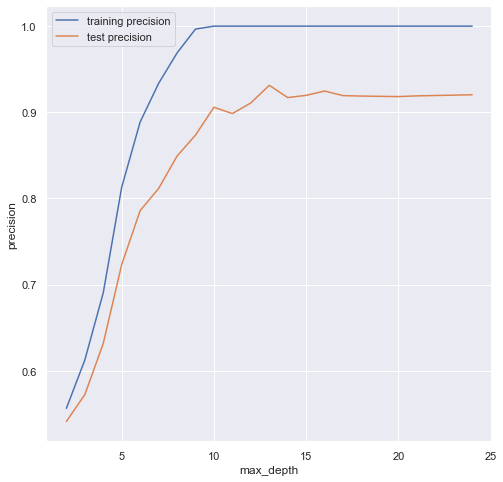


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9203646580583452
{'n_estimators': 100}


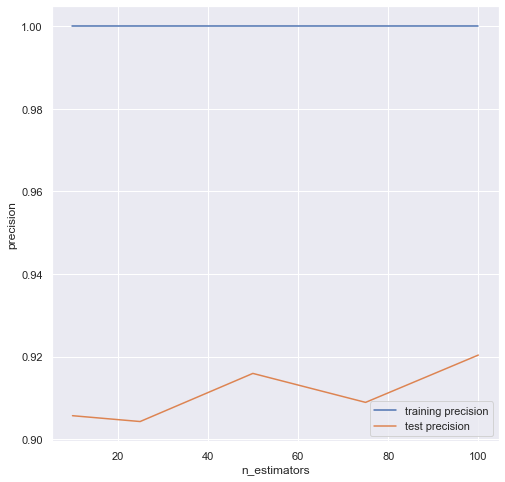


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8580992313067786
{'min_samples_split': 10}


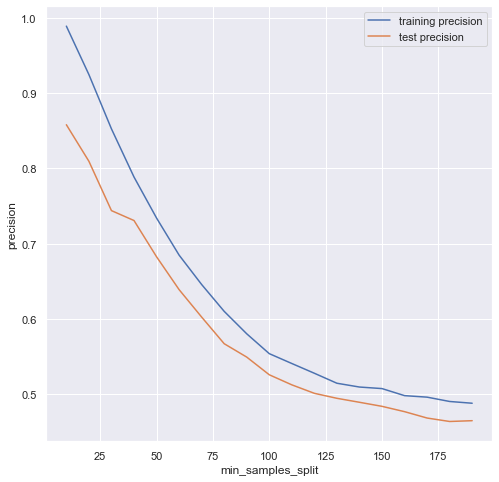


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.7349421989664776
{'min_samples_leaf': 10}


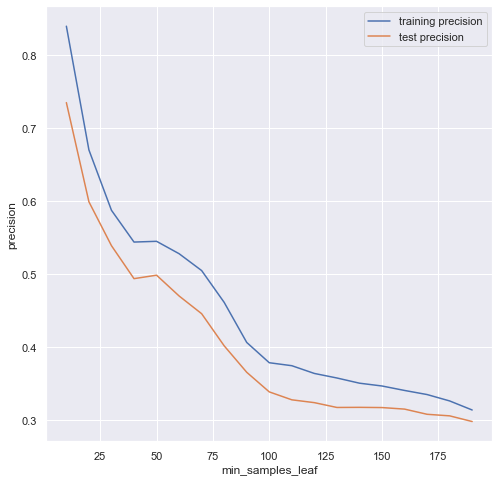


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9370118417737464
{'max_features': 5}


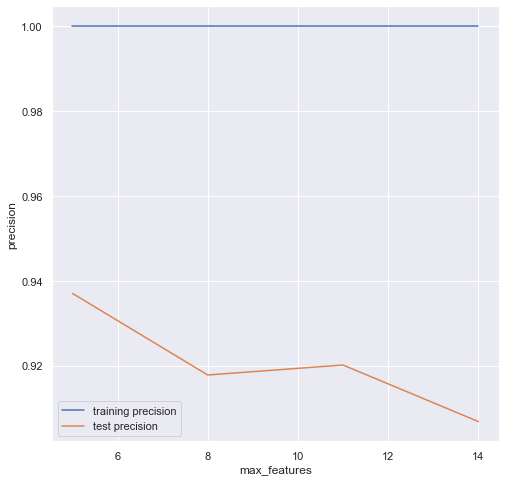



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9364177421747515
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
We can get accuracy of 0.9364177421747515 using {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}


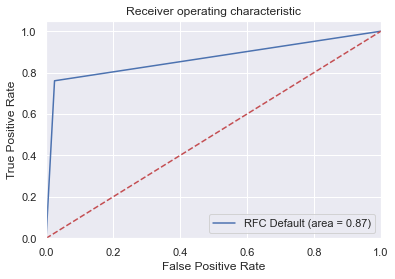

Area under curve is: 0.87
Recall for our model is: 0.76
Accuracy on test set is: 0.94
[[617  16]
 [ 28  89]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       633
           1       0.85      0.76      0.80       117

    accuracy                           0.94       750
   macro avg       0.90      0.87      0.88       750
weighted avg       0.94      0.94      0.94       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


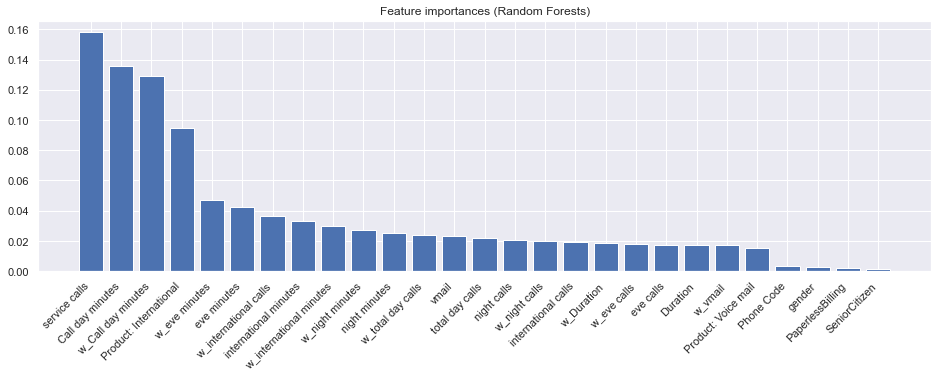

In [76]:
rf1, feats1 = Train_ML_Model(df_data)

## Hyperparameter Tuning
- Accuray increase
- AUC increase
- Recall increase

# Model 2 - Remove wieghted features

Index(['total day calls', 'eve calls', 'night minutes', 'vmail',
       'international minutes', 'gender', 'night calls', 'Product: Voice mail',
       'international calls', 'Phone Code', 'SeniorCitizen', 'Duration',
       'Call day minutes', 'PaperlessBilling', 'eve minutes',
       'Product: International', 'service calls'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8613333333333333)
Classifier: logistic_regression, Accuracy: 0.8413333333333334)
Classifier: support_vector_machines, Accuracy: 0.856)
Classifier: random_forest, Accuracy: 0.936)
Classifier: gradient_boosting, Accuracy: 0.948)


 --------------------------------------------------  Train RF Model --------------------------------------------------


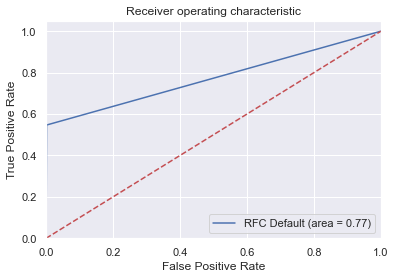

Area under curve is: 0.77
Recall for our model is: 0.55
Accuracy on test set is: 0.93
[[632   1]
 [ 53  64]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       633
           1       0.98      0.55      0.70       117

    accuracy                           0.93       750
   macro avg       0.95      0.77      0.83       750
weighted avg       0.93      0.93      0.92       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.945688916938917
{'max_depth': 24}


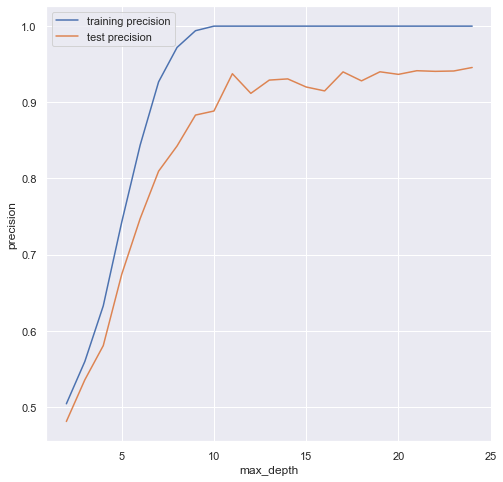


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9475063622122445
{'n_estimators': 50}


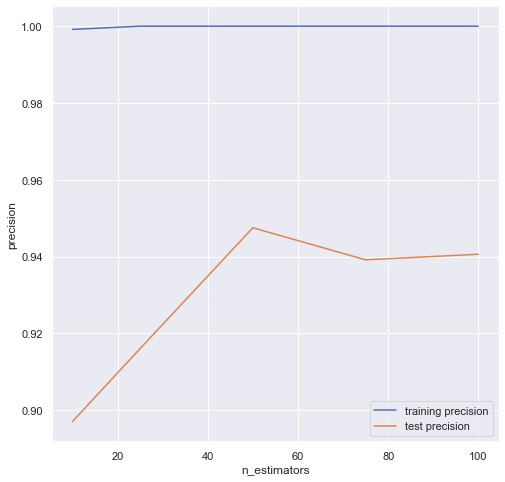


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8704417909134889
{'min_samples_split': 10}


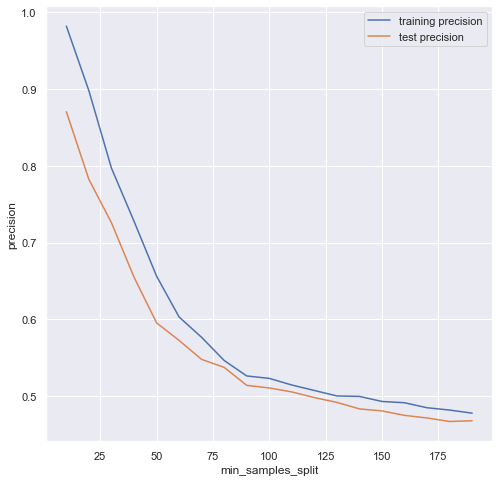


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.6618442292171105
{'min_samples_leaf': 10}


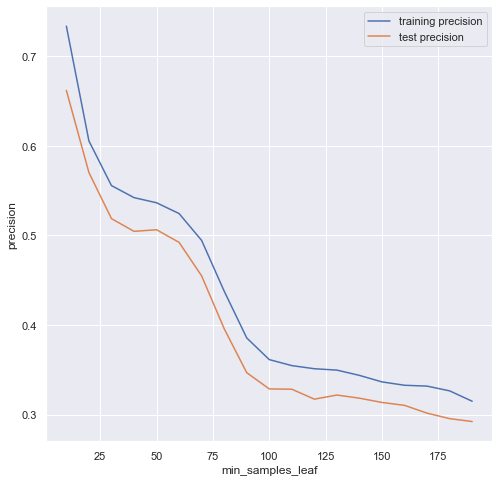


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9145468998410174
{'max_features': 5}


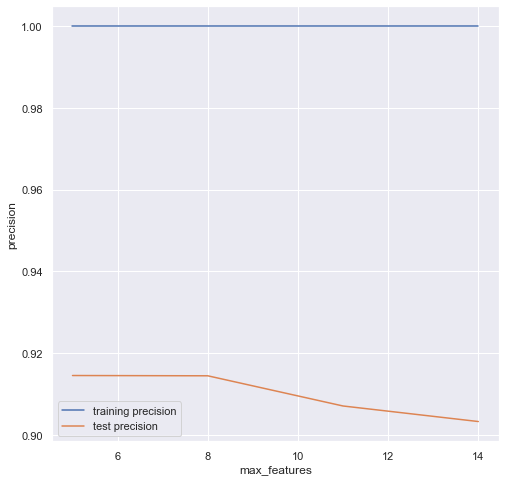



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9368633733867379
{'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}
We can get accuracy of 0.9368633733867379 using {'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}


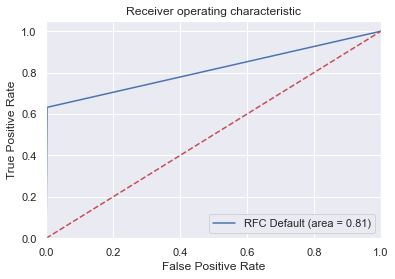

Area under curve is: 0.81
Recall for our model is: 0.63
Accuracy on test set is: 0.94
[[631   2]
 [ 43  74]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       633
           1       0.97      0.63      0.77       117

    accuracy                           0.94       750
   macro avg       0.95      0.81      0.87       750
weighted avg       0.94      0.94      0.93       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


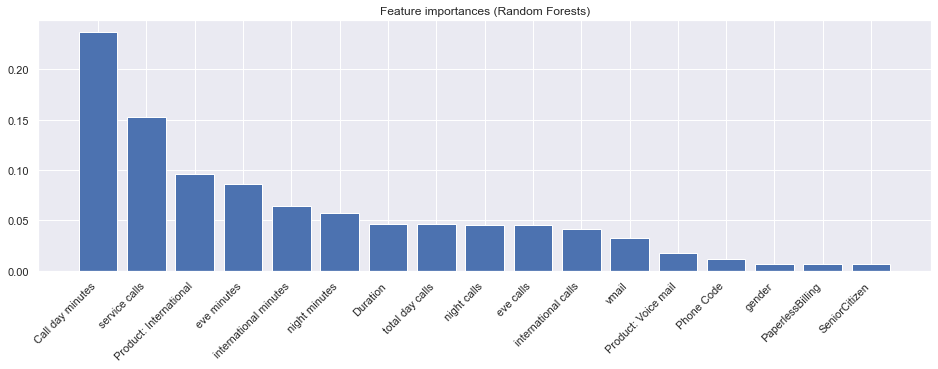

In [84]:
rf2, feats2 = Train_ML_Model(df_data[list(set(df_data.columns)-set(wieghted_feats))])

## Hyperparameter Tuning
- Accuray increase
- AUC increase
- Recall increase

# Model 3 - Remove less important feats

Index(['w_vmail', 'w_eve calls', 'night minutes', 'w_international minutes',
       'vmail', 'w_night minutes', 'international minutes',
       'w_international calls', 'Product: International',
       'Product: Voice mail', 'international calls', 'Call day minutes',
       'PaperlessBilling', 'eve minutes', 'w_Call day minutes',
       'service calls'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8893333333333333)
Classifier: logistic_regression, Accuracy: 0.8466666666666667)
Classifier: support_vector_machines, Accuracy: 0.8706666666666667)
Classifier: random_forest, Accuracy: 0.944)
Classifier: gradient_boosting, Accuracy: 0.9533333333333334)


 --------------------------------------------------  Train RF Model --------------------------------------------------


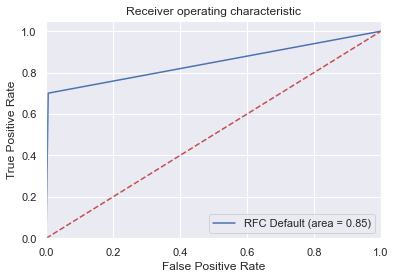

Area under curve is: 0.85
Recall for our model is: 0.7
Accuracy on test set is: 0.95
[[629   4]
 [ 35  82]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       633
           1       0.95      0.70      0.81       117

    accuracy                           0.95       750
   macro avg       0.95      0.85      0.89       750
weighted avg       0.95      0.95      0.94       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.9242875178801034
{'max_depth': 14}


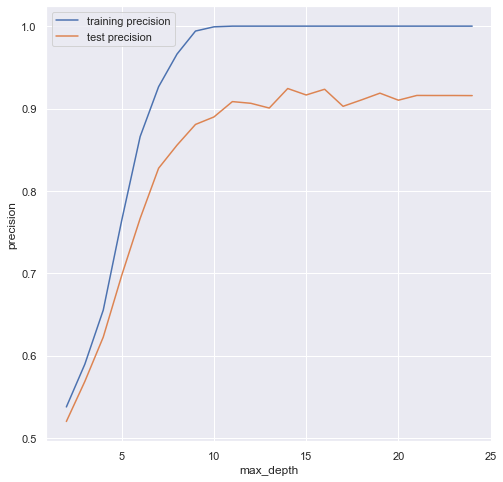


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.921313347044244
{'n_estimators': 50}


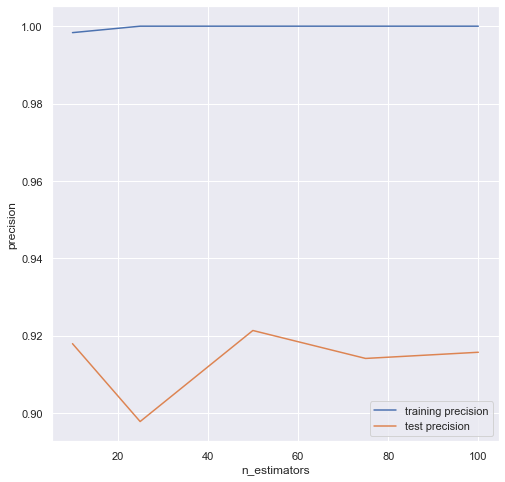


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8682527387012058
{'min_samples_split': 10}


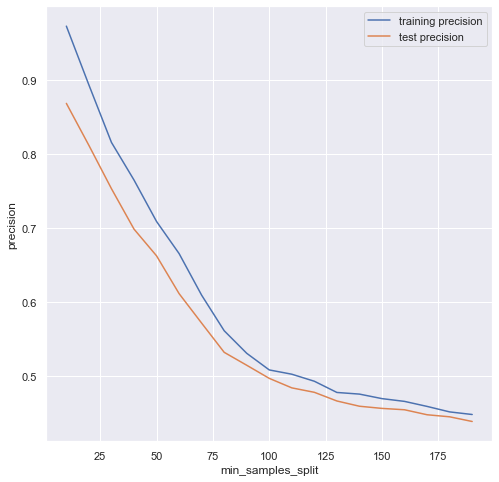


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.7289594016843274
{'min_samples_leaf': 10}


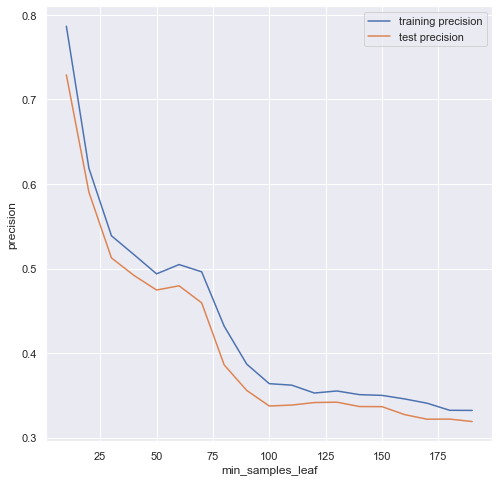


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9259873333726819
{'max_features': 5}


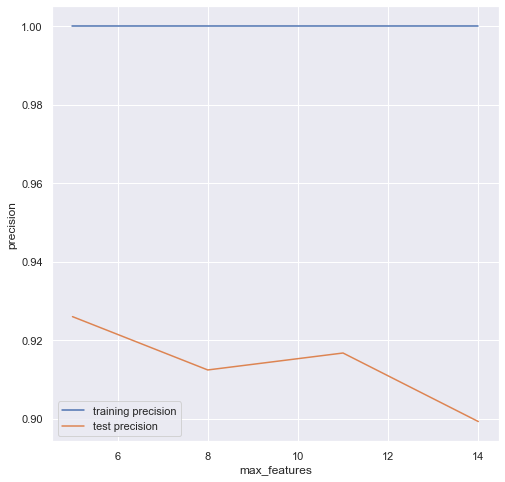



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9430891559115858
{'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}
We can get accuracy of 0.9430891559115858 using {'max_depth': 17, 'min_samples_leaf': 5, 'min_samples_split': 5}


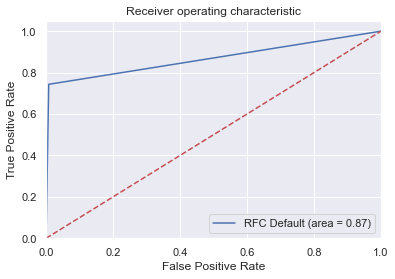

Area under curve is: 0.87
Recall for our model is: 0.74
Accuracy on test set is: 0.95
[[628   5]
 [ 30  87]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       633
           1       0.95      0.74      0.83       117

    accuracy                           0.95       750
   macro avg       0.95      0.87      0.90       750
weighted avg       0.95      0.95      0.95       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


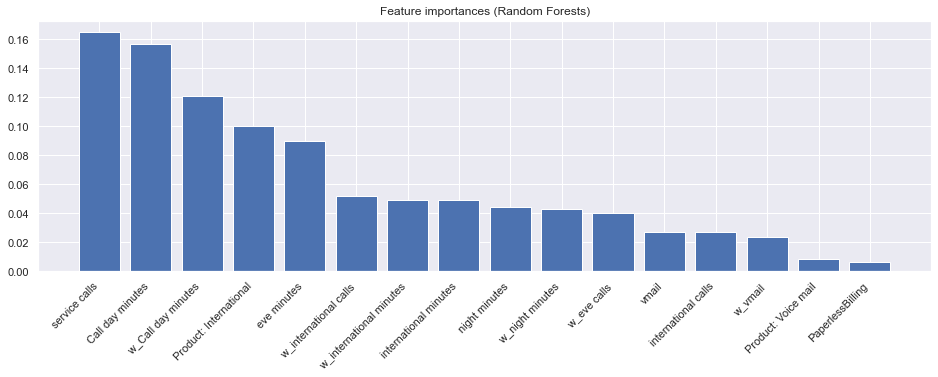

In [85]:
rf3, feats3 = Train_ML_Model(df_data[list(set(df_data.columns)-set(less_imp_feats))])

## Hyperparameter Tuning 
- AUC increase
- Recall increase

## Models performance : Model-3 > Model-2 > Model-1
Why model3 better than Model2 and Model1? 

Why Model2 better than Model1? (in terms of precision)

## Save Model as Pickle File

In [ ]:
#pickle.dump(rfc, open(f'model/RF_V001.pkl', 'wb'))

## Get Predictions for New Data Point

In [ ]:
from get_pred import Main_Pred

In [ ]:
Main_Pred('8022-BECSI')